In [1]:
import keras
from keras.layers import Conv3D,Conv2D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.layers import Add, Activation, ZeroPadding2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D,Concatenate, ReLU, LeakyReLU, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
from plotly.offline import init_notebook_mode
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

plt.style.use('Solarize_Light2')

In [2]:
init_notebook_mode(connected=True)
%matplotlib inline

In [29]:
## GLOBAL VARIABLES
dataset = 'PU'
test_ratio = 0.2
windowSize = 25

In [4]:
def loadData(name):
      
    if name == 'IP':
        data = sio.loadmat('HSI_dataset/Indian_pines_corrected.mat')['indian_pines_corrected']
        labels = sio.loadmat('HSI_dataset/Indian_pines_gt.mat')['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat('HSI_dataset/Salinas_corrected.mat')['salinas_corrected']
        labels = sio.loadmat('HSI_dataset/Salinas_gt.mat')['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat('HSI_dataset/PaviaU.mat')['paviaU']
        labels = sio.loadmat('HSI_dataset/PaviaU_gt.mat')['paviaU_gt']
    elif name == 'PC':
        data = sio.loadmat('Pavia_Dataset/Pavia.mat')['pavia']
        labels = sio.loadmat('Pavia_Dataset/Pavia_gt.mat')['pavia_gt']
    
    return data, labels
    

In [10]:
def splitTrainTestSet(X, y, testRatio, randomState=15):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y) #same random split will be generated every time
    return X_train, X_test, y_train, y_test

In [11]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [12]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [13]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [14]:
X, y = loadData(dataset)

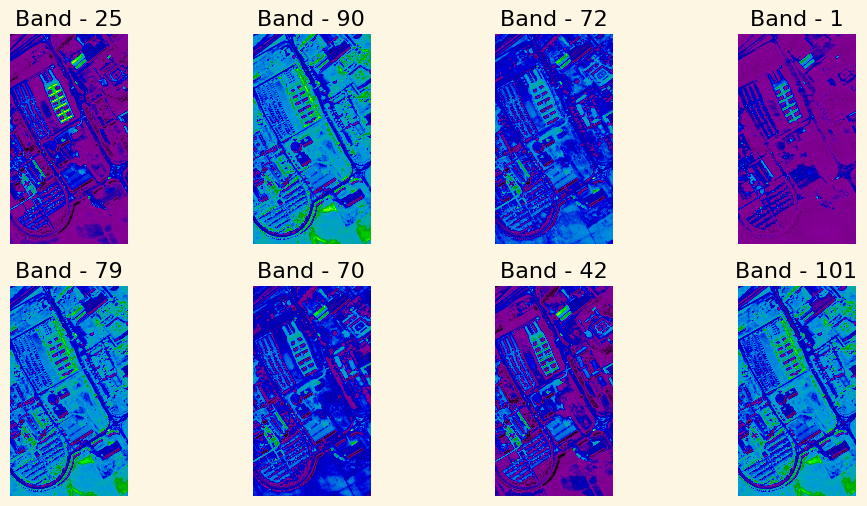

In [15]:
fig = plt.figure(figsize = (12, 6))

for i in range(1, 1+8):
    fig.add_subplot(2,4, i)
    q = np.random.randint(X.shape[2])  #random
    plt.imshow(X[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')
plt.savefig('PU_Bands.png')

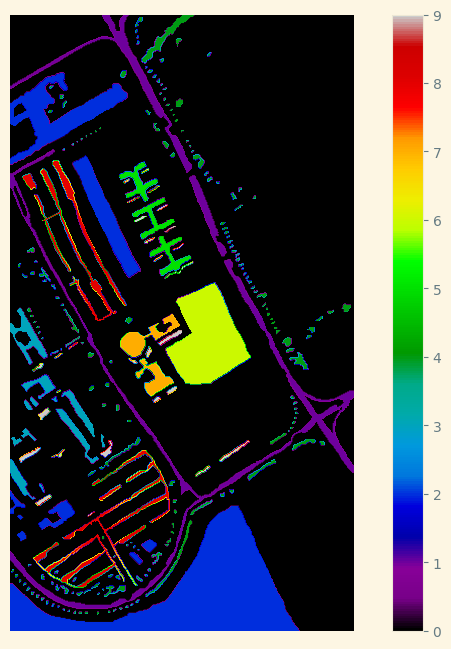

In [16]:
plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
if (dataset == 'PU' or dataset == 'PC'):
    plt.savefig('PU_GT.png') 
elif (dataset == 'Bot'):
    plt.savefig('Bot_GT.png') 
elif (dataset == 'SA'):
    plt.savefig('SA_GT.png') 
else:
    plt.savefig('IP_GT.png') 

plt.show()

In [17]:
import pandas as pd
pd.Series(y.flatten()).value_counts()

0    164624
2     18649
1      6631
6      5029
8      3682
4      3064
3      2099
5      1345
7      1330
9       947
Name: count, dtype: int64

In [18]:
def plot_class_distribution(class_labels):
    class_counts = pd.Series(y.flatten()).value_counts()
    class_counts.plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

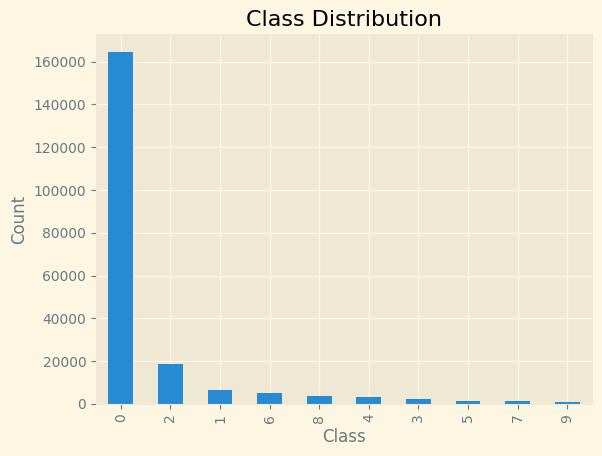

In [19]:
plot_class_distribution(y)

In [20]:
import plotly.express as px
class_counts = pd.Series(y.flatten()).value_counts()
bar_fig = px.bar(x=class_counts.index[1:], y=class_counts[1:], labels=y, color=class_counts.index[1:])
bar_fig.update_layout(
        xaxis=dict(
            title='Class',
            tickmode='array',
            tickvals=class_counts.index[1:].tolist(),
            tickangle=45
        ),
        yaxis=dict(
            title='count',
        ),
        showlegend=False
)
bar_fig.show()


In [21]:
K = X.shape[2]

In [22]:
if (dataset == 'PU' or dataset == 'PC'):
    K = 9  
elif (dataset == 'Bot'):
    K = 14 
else:
    K = 30
X,pca = applyPCA(X,numComponents=K)

X.shape

(610, 340, 9)

X.shape (610, 340, 9)
y.shape (610, 340)
EV [0.58318064 0.94418758 0.98856319 0.99157161 0.99366953 0.99544696
 0.99667817 0.99736012 0.99782334]


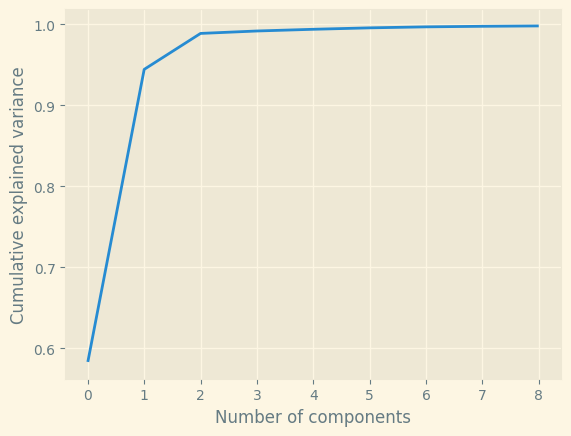

In [23]:
ev=pca.explained_variance_ratio_
print('X.shape',X.shape)
print('y.shape',y.shape)
print('EV',np.cumsum(ev))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [24]:
newX = np.reshape(X, (-1, X.shape[2]))

In [25]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((42776, 25, 25, 9), (42776,))

In [26]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, 0.2)


Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((34220, 25, 25, 9), (8556, 25, 25, 9), (34220,), (8556,))

In [27]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K)
Xtrain.shape

(34220, 25, 25, 9)

In [28]:
ytrain = to_categorical(ytrain)
ytrain.shape

(34220, 9)

In [30]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [31]:
def identity_block(X, f, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
        
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
        
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
        
    return X

In [32]:
def convolutional_block(X, f, filters, stage, block, s = 2):
        
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
   
    return X

In [33]:
def ResNet50(input_shape = (S, S, L,1), classes = output_units):
    ## input layer
    input_layer = Input(input_shape)

    ## convolutional layers
    conv_layer1 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(input_layer)
    conv3d_shape = conv_layer1.shape
    conv_layer2 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer1)
    conv_layer3 = Conv2D(filters=64, kernel_size=(5,5), activation='relu')(conv_layer2)
    bn_conv1 = BatchNormalization(axis = 3)(conv_layer3)
    bn_conv2 = Activation('relu')(bn_conv1)
    pooling_layer1 = MaxPooling2D((3, 3), strides=(2, 2))(bn_conv2)
    Conv_block = convolutional_block(pooling_layer1, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    I_b1 = identity_block(Conv_block, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(I_b1, 3, [64, 64, 256], stage=2, block='c')
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = AveragePooling2D(pool_size=(2, 2),name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)
    model = Model(inputs = input_layer , outputs = X, name='ResNet50')
    return model

In [34]:
model = ResNet50(input_shape = (S, S, L,1), classes = output_units)
##model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',top_5_accuracy])
# model.summary()

In [35]:
# compiling the model
adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

c:\Users\user\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning:

Argument `decay` is no longer supported and will be ignored.



In [36]:
# checkpoint
filepath = "best-model_IP_Source.keras"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [37]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(34220, 25, 25, 9, 1)

In [38]:
# history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)
#for key in history.history:
    #print(key)

In [39]:
# load best weights
model.load_weights("best-model_IP_Source.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [40]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K,1)
Xtest.shape

(8556, 25, 25, 9, 1)

In [41]:
ytest = to_categorical(ytest)
ytest.shape

(8556, 9)

In [42]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

268/268 ━━━━━━━━━━━━━━━━━━━━ 43s 154ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1326
           1       1.00      1.00      1.00      3730
           2       1.00      1.00      1.00       420
           3       1.00      1.00      1.00       613
           4       1.00      1.00      1.00       269
           5       1.00      1.00      1.00      1006
           6       1.00      1.00      1.00       266
           7       1.00      1.00      1.00       737
           8       1.00      1.00      1.00       189

    accuracy                           1.00      8556
   macro avg       1.00      1.00      1.00      8556
weighted avg       1.00      1.00      1.00      8556



In [43]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [44]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    conf = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(conf)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, conf, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [45]:
classification, conf, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(conf)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('DATASET ={}'.format(dataset))
    x_file.write('\n')    
    x_file.write('Test ratio ={}'.format(test_ratio))
    x_file.write('\n')
    x_file.write('Window size ={}'.format(windowSize))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

268/268 ━━━━━━━━━━━━━━━━━━━━ 37s 140ms/step
268/268 ━━━━━━━━━━━━━━━━━━━━ 47s 165ms/step - accuracy: 1.0000 - loss: 2.5308e-05


In [46]:
f = open("classification_report.txt", "r")
print(f.read()) 

DATASET =PU
Test ratio =0.2
Window size =25

0.002591925658634864 Test loss (%)
100.0 Test accuracy (%)

100.0 Kappa accuracy (%)
100.0 Overall accuracy (%)
100.0 Average accuracy (%)

                      precision    recall  f1-score   support

             Asphalt       1.00      1.00      1.00      1326
             Meadows       1.00      1.00      1.00      3730
              Gravel       1.00      1.00      1.00       420
               Trees       1.00      1.00      1.00       613
Painted metal sheets       1.00      1.00      1.00       269
           Bare Soil       1.00      1.00      1.00      1006
             Bitumen       1.00      1.00      1.00       266
Self-Blocking Bricks       1.00      1.00      1.00       737
             Shadows       1.00      1.00      1.00       189

            accuracy                           1.00      8556
           macro avg       1.00      1.00      1.00      8556
        weighted avg       1.00      1.00      1.00      8556

[[1326

In [47]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [48]:
# load the original image
X, y = loadData(dataset)

In [49]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [50]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [51]:
X.shape

(1096, 715, 9)

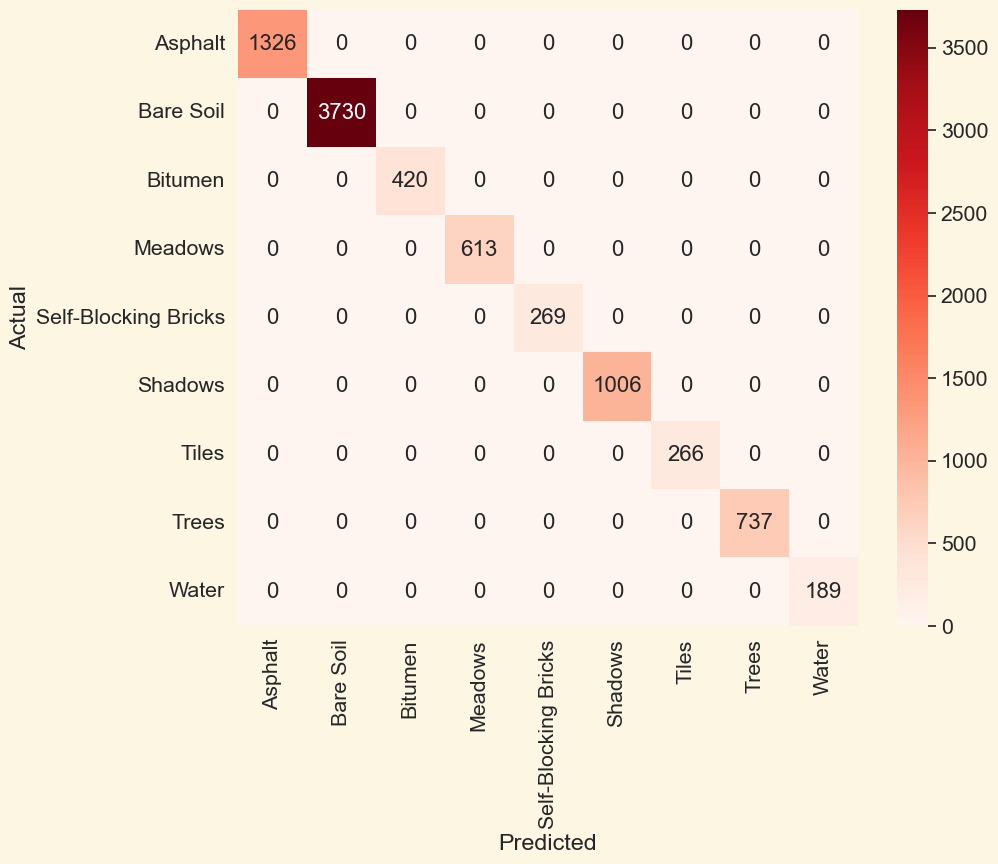

In [52]:
import pandas as pd
import seaborn as sn
if(dataset=='IP'):
    names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
elif dataset == 'SA':
    names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
elif dataset == 'PU':
    names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
elif dataset == 'PC':
    names = ['Water', 'Trees','Asphalt','Self-Blocking Bricks', 'Bitumen','Tiles', 'Shadows','Meadows','Bare Soil']  

elif(dataset=='Bot'):
    names = ['water','hippo grass','floodplain grasses1','floodplain_grasses2', 'reeds1','riparian','firescar2',
                        'island interior','acacia woodlands','acacia shrublands','acacia grasslands','short mopane','mixed mopane','exposed soils']
        

df_cm = pd.DataFrame(conf, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=1200)